In [1]:
%matplotlib inline
import sys
BIN = '/home/honey/cern/github_repo/AE-Compression-pytorch/'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm.notebook import tqdm
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from HEPAutoencoders import utils
from scipy import stats
import matplotlib as mpl
from matplotlib.pyplot import figure

from fastai import data_block, basic_train, basic_data
import fastai
from sklearn.preprocessing import StandardScaler

In [2]:
from HEPAutoencoders.nn_utils import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [4]:
train = pd.read_pickle('/home/honey/cern/datasets/all_jets_train_4D_100_percent.pkl')
testpath = '/home/honey/cern/July/datasets/processed_4D_gluino_02_10fb_'
save_dir = 'AE_PhenoML_4D-3D_400ReLU_BN_MSE_Custom-norm_gluino_02'

In [5]:
test_all = []
particle_list = ['g', 'e-', 'e+', 'm-', 'm+']
for i in particle_list:
    test_all.append(pd.read_pickle(testpath + i + '_4D.pkl'))

print(len(test_all))

5


In [6]:
train = train[:200]

In [7]:
test_all[0].head()

,E,pt,eta,phi
0,76918.601562,46416.699219,1.091430,-0.619051
1,123424.000000,39689.699219,1.800760,3.022060
2,721167.000000,167497.000000,2.139280,-0.739021
3,97650.500000,85453.500000,-0.528131,-1.610280
4,665320.000000,236257.000000,-1.695370,2.874650


In [8]:
train_ds = TensorDataset(torch.tensor(train.values, dtype=torch.float), torch.tensor(train.values, dtype=torch.float))

In [9]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [10]:
nodes = [4, 400, 400, 200, 3, 200, 400, 400, 4]
model = AE_bn_LeakyReLU(nodes)
model.train()

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=3, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
loss_func = nn.MSELoss()

In [12]:
wd = 1e-2
from fastai.callbacks import ActivationStats

In [13]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    return df

In [14]:
residual_strings = [r'$(E_{out} - E_{in}) / E_{in}$',
    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in})$',
                        r'$(\phi_{out} - \phi_{in})$',
                        ]

In [15]:
residuals = []
for i in tqdm(range(5)):
    test = test_all[i]
    variables = test.keys()
    test['E'] = test['E'] / 1000.0
    test['pt'] = test['pt'] / 1000.0

    test['eta'] = test['eta'] / 5
    test['phi'] = test['phi'] / 3
    test['E'] = np.log10(test['E']) 
    test['pt'] = np.log10(test['pt'])

    valid_ds = TensorDataset(torch.tensor(test.values, dtype=torch.float), torch.tensor(test.values, dtype=torch.float))
    train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)
    
    db = basic_data.DataBunch(train_dl, valid_dl)
    
    learn = basic_train.Learner(data=db, model=model, wd=wd, loss_func=loss_func, callback_fns=ActivationStats, true_wd=True)
    
    learn.load('best_nn_utils_bs8192_lr1e-04_wd1e-02')
    
    print('MSE on test-set ', particle_list[i], learn.validate())
    
    plt.close('all')
    unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    line_style = ['--', '-']
    colors = ['orange', 'c']
    markers = ['*', 's']

    model.to('cpu')

    # Histograms
    idxs = (0, 100000)  # Choose events to compare
    data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
    pred = model(data)
    pred = pred.detach().numpy()
    data = data.detach().numpy()

    data_df = pd.DataFrame(data, columns=test.columns)
    pred_df = pd.DataFrame(pred, columns=test.columns)

    unnormalized_data_df = custom_unnormalize(data_df)
    unnormalized_pred_df = custom_unnormalize(pred_df)
    
    data = unnormalized_data_df
    pred = unnormalized_pred_df

    r = pred - data
    rel_diff_list = ['E',
                 'pt',
                 ]

    for var in rel_diff_list:
        r[var] = r[var] / data[var]
    residuals.append(r)   

MSE on test-set  g [1.2573055e-05]


MSE on test-set  e- [5.0873867e-05]


MSE on test-set  e+ [6.45536e-05]


MSE on test-set  m- [7.6756885e-05]


MSE on test-set  m+ [9.127547e-05]



In [16]:
def sort_key(l): 
    return len(l)

E, pt, phi, eta, nitems = [], [], [], [], {}
for j in range(5):
    x = residuals[j]
    nitems[particle_list[j]] = len(x)
    E.append(x['E'])
    pt.append(x['pt'])
    eta.append(x['eta'])
    phi.append(x['phi'])
    
E.sort(key = sort_key)
pt.sort(key = sort_key)
eta.sort(key = sort_key)
phi.sort(key = sort_key)

residuals = [E, pt, eta, phi]
nitems = dict(sorted(nitems.items(), key=lambda z: z[1]))

In [17]:
len(E[0]), len(E[1]), len(E[2]), len(E[3]), len(E[4]), nitems

(1714,
 4042,
 4138,
 5539,
 5715,
 {'g': 1714, 'e+': 4042, 'e-': 4138, 'm-': 5539, 'm+': 5715})

In [18]:
len(residuals)

4

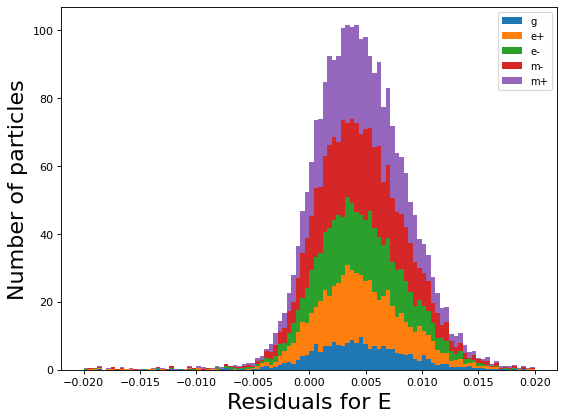

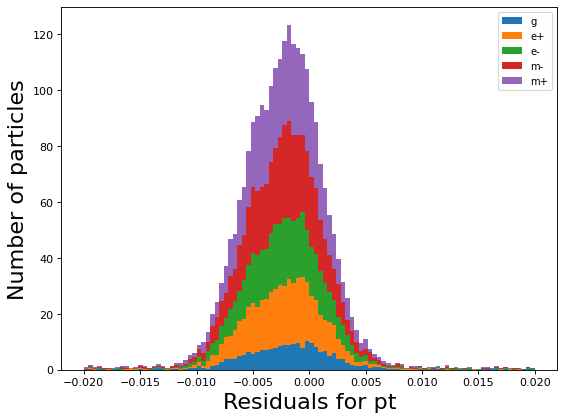

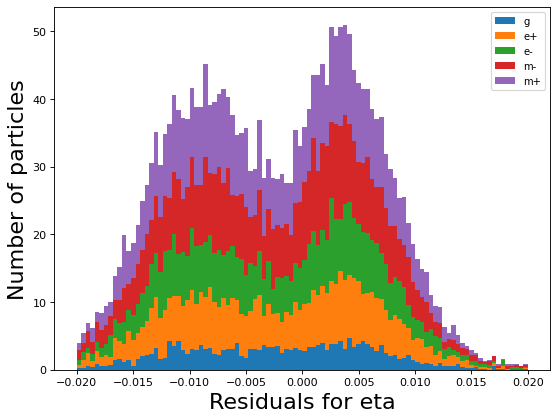

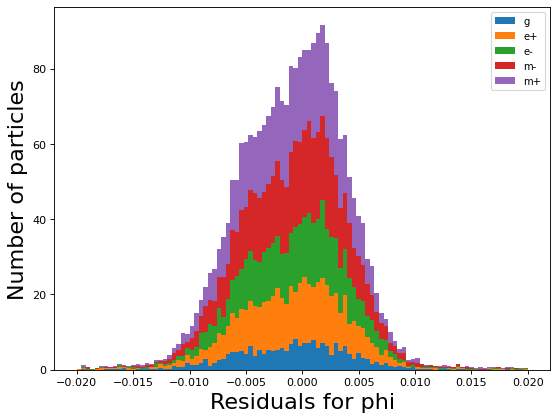

In [19]:
rang = (-0.02, 0.02)

for i in range(len(residuals)):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.hist(residuals[i], 100, stacked=True, range=rang, label=nitems.keys(), density=True)
    # plt.yscale('log')
#     plt.title()
    plt.xlabel('Residuals for %s'%variables[i], fontsize=20) 
    plt.legend(fontsize=9)
    plt.ylabel('Number of particles', fontsize = 20)
    plt.savefig(save_dir + '_residuals_%s.png'%(variables[i]))
    plt.show()